In [1]:
import pandas as pd
import numpy as np
from sargas import *
import seaborn as sns
import matplotlib.pyplot as plt

# NVT Simulation

In [2]:
def build_nvt(n, rho, t, rc, tail_correction):
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
    configuration = Configuration.from_lattice(n, rho)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, t)
    mc = MonteCarlo([displace_particle], [1], t)
    simulation = Simulation.monte_carlo(system, mc, n)
    return simulation, system

def run_simulation(simulation, equilibration, production, t):
    simulation.run(equilibration)
    simulation.deactivate_propagator_updates()
    
    properties = Observer.properties(1000)
    simulation.add_observer(properties)
    
    energy = Observer.energy(1000, 1000)
    simulation.add_observer(energy)
    widom = Observer.widom(5000, t, 1000, 10, 500)
    simulation.add_observer(widom)
    
    simulation.run(production)
    return properties, energy, widom

In [25]:
t = 0.9
sim, sys = build_nvt(500, 0.79, t, 3.0, True)
sys.box_length

8.58580401973519

In [26]:
%%time
prop, ener, wid = run_simulation(sim, 500 * 5000, 500 * 5000, t)

CPU times: user 1min 9s, sys: 128 ms, total: 1min 9s
Wall time: 1min 9s


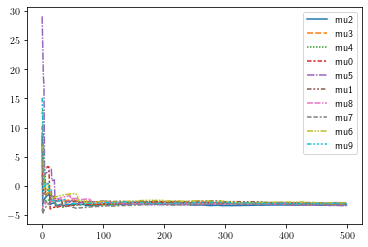

In [27]:
wdm = pd.DataFrame(wid.data)
sns.lineplot(data=wdm);

In [30]:
wdm.iloc[-1].mean() * t, 2.33 * (wdm.iloc[-1] * t).sem(ddof=1)

(-2.794098206450717, 0.11316042564896533)

In [52]:
simulation.deactivate_propagator_updates()
props = Observer.properties(1000)
simulation.add_observer(props)
widom = Observer.widom_insertion(100)
simulation.add_observer(widom)

In [57]:
simulation.run(10_000_000)

In [58]:
properties = pd.DataFrame(props.data)

In [59]:
print("u = {:.5e} +- {:.5e}".format(properties.energy.mean() / system.nparticles, properties.energy.sem() / system.nparticles))

u = -5.98412e+00 +- 3.13958e-04


In [60]:
print("p = {:.5e} +- {:.5e}".format(properties.pressure.mean(), properties.pressure.sem()))

p = 2.62406e+00 +- 1.58288e-03


# NPT

In [60]:
nparticles = 500

density = 9e-1
volume = nparticles / density
temperature = 9e-1
pressure = 2.62
rc = 3.0

potential = Potential.lennard_jones(1.0, 1.0, tail_correction=True)
# system = System.insert_particles(nparticles, volume, temperature, 15, rc, potential, nparticles, 1000000)
system = System.from_lattice(nparticles, density, temperature, rc, potential)

displace_particle = MCMove.displace_particle(0.1, 0.4, nparticles)
change_volume = MCMove.change_volume(0.1, 0.4, pressure)
mc = MonteCarlo([displace_particle, change_volume], [500, 1], temperature)

simulation = Simulation.monte_carlo(system, mc, 500)

In [61]:
%%time
simulation.run(1_000_000)

CPU times: user 10.6 s, sys: 79.6 ms, total: 10.6 s
Wall time: 10.6 s


In [62]:
#simulation.deactivate_propagator_updates()
props = Observer.properties(1000)
simulation.add_observer(props)
widom = Observer.widom_insertion(100)
simulation.add_observer(widom)

In [63]:
simulation.run(1_000_000)

In [64]:
properties = pd.DataFrame(props.data)

In [65]:
print("u = {:.5e} +- {:.5e}".format(properties.energy.mean() / system.nparticles, properties.energy.sem() / system.nparticles))

u = -4.50599e+00 +- 3.07833e-03


In [66]:
print("p = {:.5e} +- {:.5e}".format(properties.pressure.mean(), properties.pressure.sem()))

p = -4.28852e-01 +- 4.20973e-03


In [67]:
print("v = {:.5e} +- {:.5e}".format(properties.volume.mean(), properties.volume.sem()))

v = 7.65029e+02 +- 5.44804e-01


In [68]:
properties.describe()

,virial,nparticles,volume,energy,pressure,density
count,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1727.093253,500.0,765.029087,-2252.996924,-0.428852,0.653904
std,310.958458,0.0,17.228215,48.672677,0.133123,0.014853
min,-2583.005522,500.0,730.661087,-2372.723911,-0.799800,0.633183
25%,-1955.848489,500.0,752.661087,-2292.132635,-0.523056,0.642128
50%,-1741.438423,500.0,767.661087,-2241.546930,-0.433391,0.651329
75%,-1519.610404,500.0,778.661087,-2214.709897,-0.341688,0.664310
max,-772.138585,500.0,789.661087,-2144.899806,-0.024566,0.684312


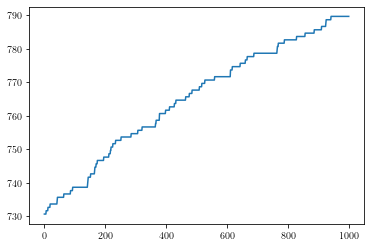

In [70]:
plt.plot(properties.volume)

# $\mu$VT Simulation

In [18]:
density = 0.5
nparticles = 500
volume = nparticles / density
temperature = 1.0

potential = Potential.lennard_jones(1.0, 1.0, tail_correction=True)
system = System.insert_particles(nparticles, volume, temperature, chemical_potential-2, 3.0, potential, nparticles + 100, 1000000)

displace_particle = MCMove.displace_particle(0.1, 0.4, nparticles)
insert_delete_particle = MCMove.insert_delete_particle(chemical_potential)
mc = MonteCarlo([displace_particle, insert_delete_particle], [3, 1], temperature)

simulation = Simulation.monte_carlo(system, mc, 500)

In [19]:
%%time
print("Equilibration")
simulation.run(nparticles * 1000)

simulation.deactivate_propagator_updates()
props = Observer.properties(100)
simulation.add_observer(props)

print("Production")
simulation.run(nparticles * 5000)

Equilibration
Production
CPU times: user 348 ms, sys: 3.96 ms, total: 352 ms
Wall time: 351 ms


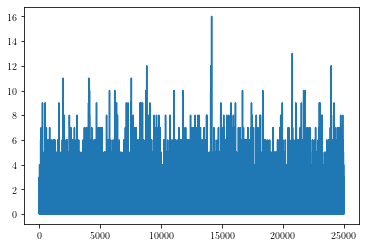

In [20]:
properties = pd.DataFrame(props.data)
plt.plot(properties.nparticles)

In [33]:
properties.nparticles

0        2.0
1        1.0
2        3.0
3        4.0
4        1.0
        ... 
24995    1.0
24996    2.0
24997    0.0
24998    2.0
24999    1.0
Name: nparticles, Length: 25000, dtype: float64